# Burst noise removal

In my opinion, before trying to do anything else, we should deal with burst noise first (if present). Burst noise is impulsive in nature and gets in the way of frequency filtering, deconvolution and even migration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rsf.api as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [2]:
sns.set_style('ticks')

## Input files

In [3]:
raw_data = 'seismic.segy'
common_shot = 'line_12_csg_raw.rsf'
mask = 'line_cdp_mask.rsf'
raw_cdp = 'line_raw_cdp.rsf'
offsets = 'line_cdp_offset.rsf'
stack = 'line_cvs_1500.rsf'
header_int = 'line_12_header_int.rsf'
header_complete = 'line_12_header_complete.rsf'

In [4]:
n2 = 120120 # Total number of traces
n3 = n2/120

## Processing steps

 - Calculate the RMS amplitude of every trace in common shot
 - See this pannel as an image. Identify possible bad spots.
 - If necessary, sort data to common receiver and analyse
 
These steps should result in a good QC image to spot bad receivers and bad spots. Usually burst noise is related to the recording equipament and sensors.

In [5]:
burst_map = 'line_12_burst_noise_map.rsf'

!sfput n2=120 n3={n3} < {common_shot} |\
    sfstack axis=1 rms=y > {burst_map}

In [6]:
burst_map = sf.Input(burst_map)

n1 = burst_map.int('n1')
n2 = burst_map.int('n2')
d1 = burst_map.float('d1')
o1 = burst_map.float('o1')

In [7]:
data = np.zeros((n2, n1), dtype=np.float32)
burst_map.read(data)

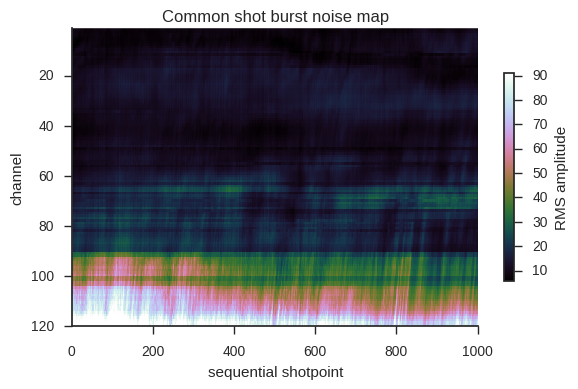

In [8]:
perc = np.percentile(data.ravel(), 99)

extent = [1, 1+n3, 120, 1]
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 cmap='cubehelix', extent=extent,
                interpolation='none')



plt.xlabel('sequential shotpoint')
plt.ylabel('channel')

plt.title('Common shot burst noise map')

sns.despine()
plt.colorbar(img, shrink=0.7, label='RMS amplitude')

plt.tight_layout()

## Important remarks

When analysing images where you are interested in high amplitude spots (semblance panels, FK panels, etc) its always good to use a well calibrated [sequential colormap](https://matplotlib.org/users/colormaps.html). The [cubehelix](http://www.mrao.cam.ac.uk/~dag/CUBEHELIX/) colormap is a excelent choice in my opinion. Also, if you are interested in individual pixel values, take care to disable pixel interpolation, as I did in this example (interpolation = 'none' parameter on imshow).

The figure above shows many important informations:

   - There is no really offensive burst noises on the line.
   - This is somewhat expected for good quality marine data, burst noise is usually a major issue on land data.
   - All shots have well balanced energy, but there is more energy on the lower left part of the image. This may be due to surface waves on the first shots of the line.
   - There is differences in receiver efficiency, as denoted by the horizontal lines on the picture.

There are methods to remove the source and receiver influence and keep only the geological respose, but its better to do that a little further down the processing flow.